![vki_logo](https://www.skywin.be/sites/default/files/logo-membres/vki_logo_blue_rectangular.jpg)
### MODULO: A package for Multiscale Proper Orthogonal Decomposition
#### Tutorial 2:  DFT, POD, SPODs and mPOD of an impinging gas jet 

This second tutorial considers a dataset which is dynamically much richer than the previous. This time 3 POD modes cannot the essence of what is happening. This data is the TR-PIV of an impinging gas jet and was extensively analyzed in previous tutorials on MODULO.
It was also discussed in the [Mendez et al, 2018](
https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/abs/multiscale-proper-orthogonal-decomposition-of-complex-fluid-flows/D078BD2873B1C30B6DD9016E30B62DA8 ) and Chapter 8 of the book [Mendez et al, 2022](https://www.cambridge.org/core/books/datadriven-fluid-mechanics/0327A1A43F7C67EE88BB13743FD9DC8D).

We refer you to those work for details on the experimental set up and the flow conditions.


#### Load packages and prepare plot customization (Optional)

In [1]:
import numpy as np # we use this to manipulate data 
import matplotlib.pyplot as plt # this is for plotting
import os  # this is to create/rename/delete folders
from modulo.modulo import MODULO # this is to create modulo objects

# these are some utility functions 
from modulo.utils.others import Plot_Field_TEXT_JET, Plot_Field_JET # plotting
from modulo.utils.others import Animation_JET # for animations 
from modulo.utils.read_db import ReadData # to read the data

# This is for plot customization
fontsize = 16
plt.rc('text', usetex=True)      
plt.rc('font', family='serif')
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['legend.fontsize'] = fontsize
plt.rcParams['font.size'] = fontsize


#### Download the dataset and store it into a local folder+ prepare folder for results

In [2]:
# Folder to store all results concerning this tutorial
FOLDER_JET_RESULTS='Results_Jet'
if not os.path.exists(FOLDER_JET_RESULTS):
    os.mkdir(FOLDER_JET_RESULTS)
    
# Folder where we extract the data 
FOLDER='Tutorial_2_JET_PIV'

# First we unzip the file (note that this is the 7th exercise in the old enumeration)
import urllib.request
print('Downloading Data for Tutorial 2...')
url = 'https://osf.io/c28de/download'
urllib.request.urlretrieve(url, 'Ex_4_TR_PIV.zip')
print('Download Completed! I prepare data Folder')
# Unzip the file 
from zipfile import ZipFile
String='Ex_4_TR_PIV.zip'
zf = ZipFile(String,'r')
zf.extractall('./')
zf.close() 
os.rename('Ex_4_TR_PIV_Jet', FOLDER) # rename the data flolder to FOLDER
os.remove(String) # Delete the zip file with the data 
print('Data set unzipped and ready ! ')


Download Completed! I prepare data Folder
Data set unzipped and ready ! 


###### Load one snapshot and plot it 
We use the functions Plot_Field_TEXT_JET to extract all the data concerning the on snapshot. In particular, we us it to extract the grid information. Note that the grid is here saved in each of the dat files, even if this is identical for all of them. This is very inefficient, but that's how the output was produced from our old PIV code. In what follows we generate the time and space grid and plot the velocity field of snapshot 10.

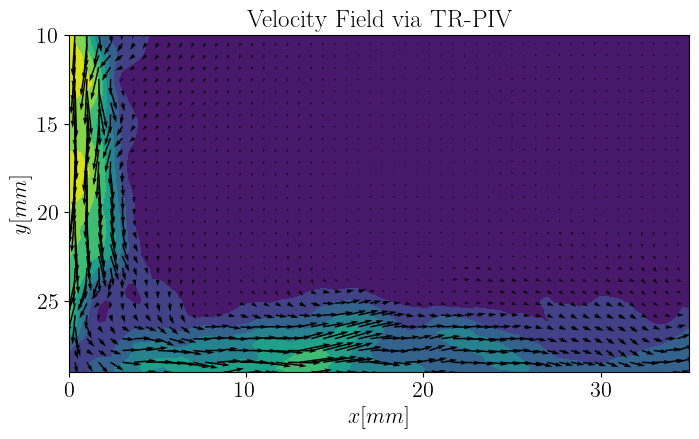

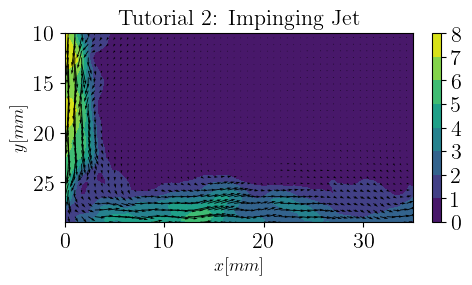

In [5]:
# Read file number 10 (Check the string construction)
SNAP=10
Name=FOLDER+os.sep+'Res%05d'%SNAP+'.dat' # Check it out: print(Name)
n_s, Xg, Yg, Vxg, Vyg, X_S,Y_S=Plot_Field_TEXT_JET(Name) 
# Shape of the grid
n_y,n_x=np.shape(Xg)

# Plot the vector field
fig, ax = plt.subplots(figsize=(5, 3)) # This creates the figure
Magn=np.sqrt(Vxg**2+Vyg**2); 
CL=plt.contourf(Xg,Yg,Magn,levels=np.arange(0,9,1))
STEPx=2; STEPy=2; 
plt.quiver(Xg[::STEPx,::STEPy],Yg[::STEPx,::STEPy],\
           Vxg[::STEPx,::STEPy],Vyg[::STEPx,::STEPy],color='k',scale=100) # Create a quiver (arrows) plot
    
plt.rc('text', usetex=True)      # This is Miguel's customization
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
fig.colorbar(CL,pad=0.05,fraction=0.025)
ax.set_aspect('equal') # Set equal aspect ratio
ax.set_xlabel('$x[mm]$',fontsize=13)
ax.set_ylabel('$y[mm]$',fontsize=13)
ax.set_title('Tutorial 2: Impinging Jet',fontsize=16)
ax.set_xticks(np.arange(0,40,10))
ax.set_yticks(np.arange(10,30,5))
ax.set_xlim([0,35])
ax.set_ylim(10,29)
ax.invert_yaxis() # Invert Axis for plotting purpose
plt.tight_layout()
Name=FOLDER+os.sep+'Snapshot_JET_'+str(SNAP)+'.png'
plt.savefig(Name, dpi=200) 
plt.show()

##### Step 1 Load the data and create snapshot matrix D


In [6]:
# Construct Time discretization
n_t=2000; Fs=2000; dt=1/Fs 
t=np.linspace(0,dt*(n_t-1),n_t) # prepare the time axis# 


# --- Component fields (N=2 for 2D velocity fields, N=1 for pressure fields)
N = 2 
# --- Number of mesh points
N_S = 6840
# --- Header (H) and footer (F) to be skipped during acquisition
H = 1; F = 0
# --- Read one sample snapshot (to get N_S)
Name = "./Tutorial_2_JET_PIV/Res00001.dat"
Dat = np.genfromtxt(Name, skip_header=H, skip_footer=F)

D = ReadData._data_processing(database=None,
                              FOLDER_OUT='./',
                              FOLDER_IN='./Tutorial_2_JET_PIV/', 
                              filename='Res%05d', 
                              h=H,f=F,c=2,
                              N=2, N_S=2*Dat.shape[0],N_T=n_t)


Data matrix was not provided, reading it from ./Tutorial_2_JET_PIV/

 
 Importing data with no partitions... 
 



100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:45<00:00, 43.89it/s]


##### Plot one snapshot  and the animation of the velocity field

To plot an animation of the velocity field, we use the function Animation_JET. This requires in input the snapshot matrix previously created


In [7]:
Name_GIF=FOLDER+os.sep+'Velocity_Field.gif'
Mex=Animation_JET(Name_GIF,D,X_S,Y_S,500,600,1)


Image n 1 of 100
Image n 2 of 100
Image n 3 of 100
Image n 4 of 100
Image n 5 of 100
Image n 6 of 100
Image n 7 of 100
Image n 8 of 100
Image n 9 of 100
Image n 10 of 100
Image n 11 of 100
Image n 12 of 100
Image n 13 of 100
Image n 14 of 100
Image n 15 of 100
Image n 16 of 100
Image n 17 of 100
Image n 18 of 100
Image n 19 of 100
Image n 20 of 100
Image n 21 of 100
Image n 22 of 100
Image n 23 of 100
Image n 24 of 100
Image n 25 of 100
Image n 26 of 100
Image n 27 of 100
Image n 28 of 100
Image n 29 of 100
Image n 30 of 100
Image n 31 of 100
Image n 32 of 100
Image n 33 of 100
Image n 34 of 100
Image n 35 of 100
Image n 36 of 100
Image n 37 of 100
Image n 38 of 100
Image n 39 of 100
Image n 40 of 100
Image n 41 of 100
Image n 42 of 100
Image n 43 of 100
Image n 44 of 100
Image n 45 of 100
Image n 46 of 100
Image n 47 of 100
Image n 48 of 100
Image n 49 of 100
Image n 50 of 100
Image n 51 of 100
Image n 52 of 100
Image n 53 of 100
Image n 54 of 100
Image n 55 of 100
Image n 56 of 100
I

## Step 1 : Perform the DFT 

We perform the (modal) DFT (see previous modulo [tutorial](https://www.youtube.com/watch?v=8fhupzhAR_M)). We fist create the folder where to export the results, then run the decomposition and export the results

In [9]:
FOLDER_DFT_RESULTS=FOLDER+os.sep+'DFT_Results_Jet'
if not os.path.exists(FOLDER_DFT_RESULTS):
    os.mkdir(FOLDER_DFT_RESULTS)

# We perform the DFT first
# --- Initialize MODULO object
m = MODULO(data=D)
# --- Check for D
D = m._data_processing(MR=True) # We remove the mean (stationary flow )!
# Compute the DFT
Sorted_Freqs, Phi_F, Sorted_Sigmas = m.compute_DFT(Fs)

# Shape of the grid
nxny=m.D.shape[0]//2; 

MODULO (MODal mULtiscale pOd) is a software developed at the von Karman Institute to perform data driven modal decomposition of numerical and experimental data. 

Modulo assumes you have a uniform grid. If not, please give the weights as parameters of MODULO!


NameError: name 'DataMatrix' is not defined

#### Export the DFT results and all the modes from 200 to 220!

NameError: name 'Sorted_Freqs' is not defined

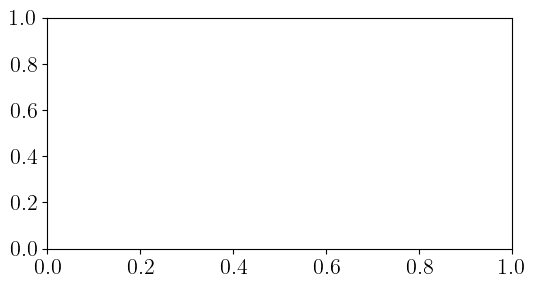

In [8]:
# Check the spectra of the DFT
fig, ax = plt.subplots(figsize=(6, 3)) # This creates the figure
plt.plot(Sorted_Freqs,20*np.log10((Sorted_Sigmas/np.sqrt((nxny*n_t)))),'ko')
plt.xlim([0,1000])
plt.ylim([-45,2])
plt.xlabel('$ f [Hz]$',fontsize=18)
plt.ylabel('$\sigma_{\mathcal{F}r}/(n_s n_r)$ [dB]',fontsize=18)
plt.tight_layout(pad=0.6, w_pad=0.3, h_pad=0.8)
Name=FOLDER_DFT_RESULTS+os.sep+'DFT_Spectra_Impinging_JET.png'
plt.savefig(Name, dpi=200) 

# Check the spectra of the DFT
fig, ax = plt.subplots(figsize=(6, 3)) # This creates the figure
plt.plot(Sorted_Sigmas[0:n_t-1]/np.max(Sorted_Sigmas),'ko:')
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlim([0,n_t-1])
plt.xlabel('$r$',fontsize=18)
plt.ylabel('$\sigma_{\mathcal{F}r}/(\sigma_{\mathcal{F}1})$',fontsize=18)
plt.tight_layout(pad=0.6, w_pad=0.3, h_pad=0.8)
Name=FOLDER_DFT_RESULTS+os.sep+'DFT_R_Impinging_JET.png'
plt.savefig(Name, dpi=200) 


## DFT Conclusions

The DFT identified a lot of modes with a single frequency. We see that there is something going on around 250Hz and 500 Hz but the decomposition was very redundant (modes 201 and 202 have almost the same frequency and thus almost the same spatial structures). As a result, the convergence was poor.


We can plot an animation using the first 50 DFT modes. First, construct an approximation of D in the DFT spectra, then animate:

In [7]:
plt.ioff()
Name_GIF=FOLDER_DFT_RESULTS+os.sep+'Full_data.gif'
Mex=Animation_JET(Name_GIF,m.D,X_S,Y_S,500,600,1)

# We can build an approximation as follows
R=50
# Re-build the Temporal Basis from the frequencies sorted by amplitude
Psi_F_t=np.zeros((n_t,R),dtype=complex)
for r in range(R):
    Psi_F_t[:,r]=1/np.sqrt(n_t)*np.exp(2*np.pi*1j*Sorted_Freqs[r]*t)
# Take only the first 50 modes     
Phi_F_t=Phi_F[:,0:R]
Sigma_F_t=Sorted_Sigmas[0:R]
# Summation over the selected leading modes
D_F=np.real(np.linalg.multi_dot([Phi_F_t,np.diag(Sigma_F_t),Psi_F_t.T]) )

Error=np.linalg.norm(m.D-D_F)/np.linalg.norm(m.D)

print('Convergence Error: E_C='+"{:.2f}".format(Error*100)+' %')

Name_GIF=FOLDER_DFT_RESULTS+os.sep+'DFT_Approximation_R50.gif'

Mex=Animation_JET(Name_GIF,D_F,X_S,Y_S,500,600,1)

Image n 1 of 100
Image n 2 of 100
Image n 3 of 100
Image n 4 of 100
Image n 5 of 100
Image n 6 of 100
Image n 7 of 100
Image n 8 of 100
Image n 9 of 100
Image n 10 of 100
Image n 11 of 100
Image n 12 of 100
Image n 13 of 100
Image n 14 of 100
Image n 15 of 100
Image n 16 of 100
Image n 17 of 100
Image n 18 of 100
Image n 19 of 100
Image n 20 of 100
Image n 21 of 100
Image n 22 of 100
Image n 23 of 100
Image n 24 of 100
Image n 25 of 100
Image n 26 of 100
Image n 27 of 100
Image n 28 of 100
Image n 29 of 100
Image n 30 of 100
Image n 31 of 100
Image n 32 of 100
Image n 33 of 100
Image n 34 of 100
Image n 35 of 100
Image n 36 of 100
Image n 37 of 100
Image n 38 of 100
Image n 39 of 100
Image n 40 of 100
Image n 41 of 100
Image n 42 of 100
Image n 43 of 100
Image n 44 of 100
Image n 45 of 100
Image n 46 of 100
Image n 47 of 100
Image n 48 of 100
Image n 49 of 100
Image n 50 of 100
Image n 51 of 100
Image n 52 of 100
Image n 53 of 100
Image n 54 of 100
Image n 55 of 100
Image n 56 of 100
I

## Step 2: Perform POD analysis


With the POD, we put no constraints on the frequency content of each mode and instead seek to find the optimal basis, i.e., the one able to represent the data with the least amount of modes.
We compute the POD with the snapshot method, using scipy's eigsh for the diagonalization. However, we also initialize the modulo object with an svd solver, which we will use for other decompositions in the following. 

After having studied tutorial 1, the code for the decomposition and the plot that follows should be fairly easy to follow.


In [8]:
# --- Initialize MODULO object
m2 = MODULO(data=m.D, # this is the dataset from the previous modulo object
           n_Modes=50, # we compute only the leading 50 pod modes
           eig_solver= 'eigsh',   # eig solver for h matrices
           svd_solver= 'svd_sklearn_randomized', # this is the fastest approach
           )
# --- Check for D
D = m2._data_processing()

Phi_P, Psi_P, Sigma_P = m2.compute_POD_K() # POD via snapshot's method.


FOLDER_POD_RESULTS=FOLDER_JET_RESULTS+os.sep+'POD_Results_Jet'
if not os.path.exists(FOLDER_POD_RESULTS):
    os.mkdir(FOLDER_POD_RESULTS)


# Plot the decomposition convergence

fig, ax = plt.subplots(figsize=(6, 3)) # This creates the figure
plt.plot(Sigma_P/np.max(Sigma_P),'ko:')
# ax.set_yscale('log'); ax.set_xscale('log')
plt.xlabel('$r$',fontsize=18)
plt.ylabel('$\sigma_{\mathcal{P}r}/(\sigma_{\mathcal{P}1})$',fontsize=18)
plt.tight_layout(pad=0.6, w_pad=0.3, h_pad=0.8)
Name=FOLDER_POD_RESULTS+os.sep+'POD_R_Impinging_JET.png'
plt.savefig(Name, dpi=200) 

# Plot the leading POD modes and their spectra:
    
# Show modes
for j in range(1,10):
 plt.close(fig='all') 
 fig, ax3= plt.subplots(figsize=(5,6))   
 ax=plt.subplot(2,1,1)
 plt.rc('text', usetex=True)    
 plt.rc('font', family='serif')
 plt.rc('xtick',labelsize=12)
 plt.rc('ytick',labelsize=12)
 V_X=Phi_P[0:nxny,j-1]
 V_Y=Phi_P[nxny::,j-1]
 Plot_Field_JET(X_S,Y_S,V_X,V_Y,True,2,1)
 #plt.quiver(X_S,Y_S,V_X,V_Y)
 ax.set_aspect('equal') # Set equal aspect ratio
 ax.set_xticks(np.arange(0,40,10))
 ax.set_yticks(np.arange(10,30,5))
 ax.set_xlim([0,35])
 ax.set_ylim([10,29])
 ax.set_xlabel('$x[mm]$',fontsize=13)
 ax.set_ylabel('$y[mm]$',fontsize=13)
 ax.invert_yaxis() # Invert Axis for plotting purpose
 String_y='$\phi_{\mathcal{S}'+str(j)+'}$'
 plt.title(String_y,fontsize=18)
 plt.tight_layout(pad=1, w_pad=0.5, h_pad=1.0)
 
 ax=plt.subplot(2,1,2)
 Signal=Psi_P[:,j-1]
 s_h=np.abs((np.fft.fft(Signal-Signal.mean())))
 Freqs=np.fft.fftfreq(int(n_t))*Fs
 plt.plot(Freqs*(4/1000)/6.5,s_h,'-',linewidth=1.5)
 plt.xlim(0,0.38)    
 plt.xlabel('$St[-]$',fontsize=18)
 String_y='$\widehat{\psi}_{\mathcal{S}'+str(j)+'}$'
 plt.ylabel(String_y,fontsize=18)
 plt.tight_layout(pad=1, w_pad=0.5, h_pad=1.0)
 Name=FOLDER_POD_RESULTS+os.sep+'POD_s_Mode_'+str(j)+'.png'
 print(Name+' Saved')
 plt.savefig(Name, dpi=300) 


 Computing Temporal correlation matrix K ...

 Done.
Saving POD temporal basis
Completing Spatial Structures Modes: 



100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 6223.56it/s]


Results_Jet\POD_Results_Jet\POD_s_Mode_1.png Saved
Results_Jet\POD_Results_Jet\POD_s_Mode_2.png Saved
Results_Jet\POD_Results_Jet\POD_s_Mode_3.png Saved
Results_Jet\POD_Results_Jet\POD_s_Mode_4.png Saved
Results_Jet\POD_Results_Jet\POD_s_Mode_5.png Saved
Results_Jet\POD_Results_Jet\POD_s_Mode_6.png Saved
Results_Jet\POD_Results_Jet\POD_s_Mode_7.png Saved
Results_Jet\POD_Results_Jet\POD_s_Mode_8.png Saved
Results_Jet\POD_Results_Jet\POD_s_Mode_9.png Saved


Study the results in the folder. The convergence is much stronger than in the DFT. However the modes have a broad range of frequencies. This is the spectral mixing described in [Mendez et al, 2018](
https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/abs/multiscale-proper-orthogonal-decomposition-of-complex-fluid-flows/D078BD2873B1C30B6DD9016E30B62DA8 ) and Chapter 8 of the book [Mendez et al, 2022](https://www.cambridge.org/core/books/datadriven-fluid-mechanics/0327A1A43F7C67EE88BB13743FD9DC8D). Here we plot an animation of the flow field using the leading 50 POD modes. You should compare this with the one of the full dataset 

In [9]:
# Here is the approximation with the leading 10 POD modes
D_P=np.real(np.linalg.multi_dot([Phi_P,np.diag(Sigma_P),Psi_P.T]) )
Error=np.linalg.norm(m.D-D_P)/np.linalg.norm(m.D)

print('Convergence Error: E_C='+"{:.2f}".format(Error*100)+' %')

Name_GIF=FOLDER_POD_RESULTS+os.sep+'POD_Approximation_R50.gif'
Mex=Animation_JET(Name_GIF,D_P,X_S,Y_S,500,600,1)

Convergence Error: E_C=49.50 %
Image n 1 of 100
Image n 2 of 100
Image n 3 of 100
Image n 4 of 100
Image n 5 of 100
Image n 6 of 100
Image n 7 of 100
Image n 8 of 100
Image n 9 of 100
Image n 10 of 100
Image n 11 of 100
Image n 12 of 100
Image n 13 of 100
Image n 14 of 100
Image n 15 of 100
Image n 16 of 100
Image n 17 of 100
Image n 18 of 100
Image n 19 of 100
Image n 20 of 100
Image n 21 of 100
Image n 22 of 100
Image n 23 of 100
Image n 24 of 100
Image n 25 of 100
Image n 26 of 100
Image n 27 of 100
Image n 28 of 100
Image n 29 of 100
Image n 30 of 100
Image n 31 of 100
Image n 32 of 100
Image n 33 of 100
Image n 34 of 100
Image n 35 of 100
Image n 36 of 100
Image n 37 of 100
Image n 38 of 100
Image n 39 of 100
Image n 40 of 100
Image n 41 of 100
Image n 42 of 100
Image n 43 of 100
Image n 44 of 100
Image n 45 of 100
Image n 46 of 100
Image n 47 of 100
Image n 48 of 100
Image n 49 of 100
Image n 50 of 100
Image n 51 of 100
Image n 52 of 100
Image n 53 of 100
Image n 54 of 100
Image 

## Step 3: Perform SPOD_t analysis

We now perform Towne's et al Spectral POD, see [Towne et al 2018](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/abs/spectral-proper-orthogonal-decomposition-and-its-relationship-to-dynamic-mode-decomposition-and-resolvent-analysis/EC2A6DF76490A0B9EB208CC2CA037717)

This decomposition combines ideas from Pwelch's spectral method and the POD. In short, we first compute the DFT in various (potentially overlapping) chunks of the dataset and for each of these we construct a snapshot matrix taking the outcomes of the DFT frequency by frequency. On these snapshot matrices, we then perform the POD (see tutorial XXXX) 

In [10]:
FOLDER_sPOD_RESULTS=FOLDER_JET_RESULTS+os.sep+'sPOD_t_Results_Jet'
if not os.path.exists(FOLDER_sPOD_RESULTS):
    os.mkdir(FOLDER_sPOD_RESULTS)

# Initialize a 'MODULO Object'
m3 = MODULO(data=m.D,MEMORY_SAVING=False)
# Prepare (partition) the dataset
# Compute the POD
Phi_SP, Sigma_SP, Freqs_Pos = m3.compute_SPOD_t(F_S=2000, # sampling frequency
                                                L_B=200, # Length of the chunks for time average
                                                O_B=150, # Overlap between chunks
                                                n_Modes=3) # number of modes PER FREQUENCY


# Plot the SPOD Spectra:
f_hat=Freqs_Pos*(4/1000)/6.5

fig, ax = plt.subplots(figsize=(6, 3)) # This creates the figure
plt.plot(f_hat, (Sigma_SP[0,:]/Sigma_SP[0,0]),'ko:')
plt.xlim([0,0.5])
plt.xlabel('$St= f H/U [-]$',fontsize=18)
plt.tight_layout(pad=0.6, w_pad=0.3, h_pad=0.8)
Name=FOLDER_sPOD_RESULTS+os.sep+'SPOD_t_Jet.png'
plt.savefig(Name, dpi=200) 

# We here plot the structures of some of the modes

Ind_1=5 # Mode 5

fig, ax3= plt.subplots(figsize=(5,3))   
V_X=Phi_SP[0:nxny,0,Ind_1]
V_Y=Phi_SP[nxny::,0,Ind_1]
Plot_Field_JET(X_S,Y_S,V_X,V_Y,True,2,1)
  #plt.quiver(X_S,Y_S,V_X,V_Y)
ax3.set_aspect('equal') # Set equal aspect ratio
ax3.set_xticks(np.arange(0,40,10))
ax3.set_yticks(np.arange(10,30,5))
ax3.set_xlim([0,35])
ax3.set_ylim([10,29])
ax3.set_xlabel('$x[mm]$',fontsize=8)
ax3.set_ylabel('$y[mm]$',fontsize=8)
ax3.invert_yaxis() # Invert Axis for plotting purpose
String_y='$\phi_{\mathcal{S}'+str(Ind_1)+'}$'
plt.title(String_y,fontsize=18)
plt.tight_layout(pad=1, w_pad=0.5, h_pad=1.0)
Name=FOLDER_sPOD_RESULTS+os.sep+'SPOD_t_Jet_'+str(Ind_1)+'.png'
plt.savefig(Name, dpi=200) 



Ind_2=25 # Mode 25

fig, ax3= plt.subplots(figsize=(5,3))   
V_X=Phi_SP[0:nxny,0,Ind_2]
V_Y=Phi_SP[nxny::,0,Ind_2]
Plot_Field_JET(X_S,Y_S,V_X,V_Y,True,2,1)
  #plt.quiver(X_S,Y_S,V_X,V_Y)
ax3.set_aspect('equal') # Set equal aspect ratio
ax3.set_xticks(np.arange(0,40,10))
ax3.set_yticks(np.arange(10,30,5))
ax3.set_xlim([0,35])
ax3.set_ylim([10,29])
ax3.set_xlabel('$x[mm]$',fontsize=8)
ax3.set_ylabel('$y[mm]$',fontsize=8)
ax3.invert_yaxis() # Invert Axis for plotting purpose
String_y='$\phi_{\mathcal{S}'+str(Ind_2)+'}$'
plt.title(String_y,fontsize=18)
plt.tight_layout(pad=1, w_pad=0.5, h_pad=1.0)
Name=FOLDER_sPOD_RESULTS+os.sep+'SPOD_t_Jet_'+str(Ind_2)+'.png'
plt.savefig(Name, dpi=200) 
    



Ind_3=48 # Mode 48


fig, ax3= plt.subplots(figsize=(5,3))   
V_X=Phi_SP[0:nxny,0,Ind_3]
V_Y=Phi_SP[nxny::,0,Ind_3]
Plot_Field_JET(X_S,Y_S,V_X,V_Y,True,2,2)
  #plt.quiver(X_S,Y_S,V_X,V_Y)
ax3.set_aspect('equal') # Set equal aspect ratio
ax3.set_xticks(np.arange(0,40,10))
ax3.set_yticks(np.arange(10,30,5))
ax3.set_xlim([0,35])
ax3.set_ylim([10,29])
ax3.set_xlabel('$x[mm]$',fontsize=8)
ax3.set_ylabel('$y[mm]$',fontsize=8)
ax3.invert_yaxis() # Invert Axis for plotting purpose
String_y='$\phi_{\mathcal{S}'+str(Ind_3)+'}$'
plt.title(String_y,fontsize=18)
plt.tight_layout(pad=1, w_pad=0.5, h_pad=1.0)
Name=FOLDER_sPOD_RESULTS+os.sep+'SPOD_t_Jet_'+str(Ind_3)+'.png'
plt.savefig(Name, dpi=200) 
    

Computing PSD at all points

Partitioned into blocks of length n_B=200
Number of partitions retained is n_P=13
Computing DFTs in each partition


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]C:\Users\mendez\OneDrive - vki.ac.be\Documents\GitHub\modulo_vki\examples\modulo\core\_spod_t.py:73: ComplexWarning: Casting complex values to real discards the imaginary part
  D_P_hat_Tens[:, :, k] = np.fft.fft(D_p, N_B, 1)
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.01it/s]


Computing POD for each frequency


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 33.01it/s]


PermissionError: [Errno 13] Permission denied: '/SPOD_Tspod_t.npz'

### SPOD_t Conclusions 

 Thanks to the averaging procedure, we have smoother spectra and slightly smoother spatial structures. We can't say much about convergence because rebuilding the flow is not trivial; we would need many modes.



## Step 4: Perform SPOD_s analysis